In [3]:
from datetime import datetime
import numpy as np
import pandas as pd
import dotenv
import os
import matplotlib.pyplot as plt
import requests
from requests.auth import HTTPBasicAuth
import seaborn as sns
from scipy import stats
from tqdm.notebook import tqdm
from statistics import median, stdev, variance

plt.rcParams["font.family"] = "Arial"
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 12
plt.rcParams["ytick.major.size"] = 12
plt.rcParams["xtick.major.pad"] = 18
plt.rcParams["ytick.major.pad"] = 18
plt.rcParams['axes.linewidth'] = 1.0

dotenv.load_dotenv()

True

In [15]:
headers = {"Authorization": f"Bearer {os.environ.get('GITHUB_TOKEN')}"}


def run_query(query):
    request = requests.post('https://api.github.com/graphql', json={'query': query}, headers=headers)
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception("Query failed to run by returning code of {}. {}".format(request.status_code, query))
        
x = np.linspace(0, 3000, 500)

def fermi(x, beta, mu):
    return 1 / (np.exp(beta*(x - mu)) + 1)

## Python の有名OSSで Pull Request の大きさがどのくらいになっているか検証

### 1つのPRに何個のCommitが含まれているか

In [5]:
query = """
{
    repository(name: "requests", owner: "psf") {
        pullRequests(first: 10) {
            nodes {
                commits(first: 1) {
                    totalCount
                }
            }
        }
    }
}
"""
result = run_query(query) # Execute the query
result

{'data': {'repository': {'pullRequests': {'nodes': [{'commits': {'totalCount': 7}},
     {'commits': {'totalCount': 1}},
     {'commits': {'totalCount': 2}},
     {'commits': {'totalCount': 2}},
     {'commits': {'totalCount': 1}},
     {'commits': {'totalCount': 1}},
     {'commits': {'totalCount': 2}},
     {'commits': {'totalCount': 2}},
     {'commits': {'totalCount': 1}},
     {'commits': {'totalCount': 1}}]}}}}

In [6]:
repos = {
    "django": "django",
    "requests": "psf",
    "ansible": "ansible",
    "keras": "keras-team",
    "flask": "pallets",
    "scikit-learn": "scikit-learn",
    "pandas": "pandas-dev",
    "pipenv": "pypa",
    "airflow": "apache",
    "luigi": "spotify"
}

In [83]:
commits_per_prs = []

for repo, owner in tqdm(repos.items()):
    query = '{\n    repository(name: "' + repo + '", owner: "' + owner + '") {' + \
    """
        pullRequests(first: 100) {
            nodes {
                commits(first: 1) {
                    totalCount
                }
            }
        }
    }
}
    """
    result = run_query(query)
    prs = result["data"]["repository"]["pullRequests"]["nodes"]
    
    for pr in prs:
        commits_per_prs.append(pr["commits"]["totalCount"])

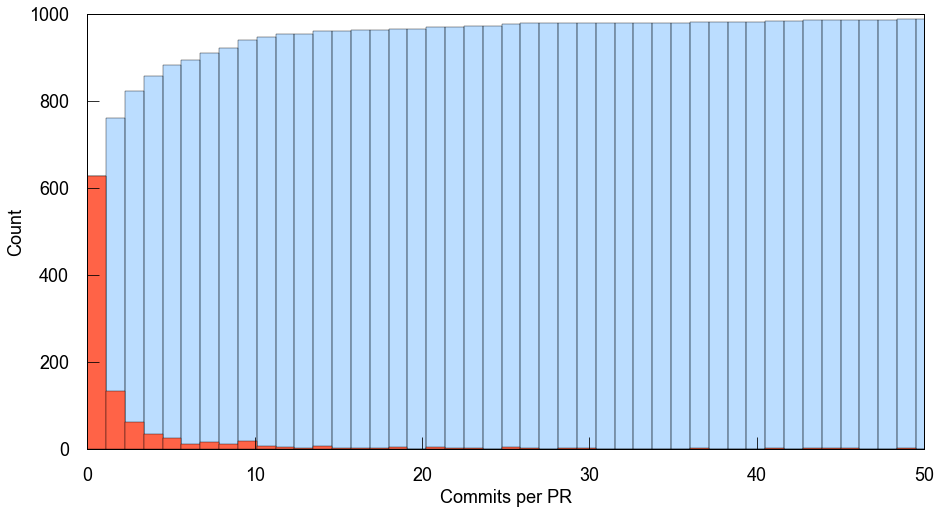

In [86]:
plt.figure(figsize=(15, 8))
sns.histplot(commits_per_prs, bins=200, cumulative=True, color="dodgerblue", alpha=0.3)
sns.histplot(commits_per_prs, bins=200, cumulative=False, color="tomato", alpha=1)
plt.xlim(0, 50)
plt.ylim(0, 1000)
plt.xlabel("Commits per PR", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.show()

In [96]:
median(commits_per_prs)

1.0

In [105]:
stdev(commits_per_prs)

14.762195582582505

### 1つのPRの変更差分はどれくらいか

In [54]:
changes = []

for repo, owner in tqdm(repos.items()):
    query = '{\n    repository(name: "' + repo + '", owner: "' + owner + '") {' + \
    """
        pullRequests(first: 100) {
            nodes {
                commits(first: 15) {
                    nodes {
                        commit {
                            additions
                            deletions
                        }
                    }
                }
            }
        }
    }
}
    """
    try:
        result = run_query(query)
    except:
        continue
        
    prs = result["data"]["repository"]["pullRequests"]["nodes"]
    
    for pr in prs:
        tmp = 0
        commits = pr["commits"]["nodes"]
        for commit in commits:
            tmp += commit["commit"]["additions"]
        
        changes.append(tmp)

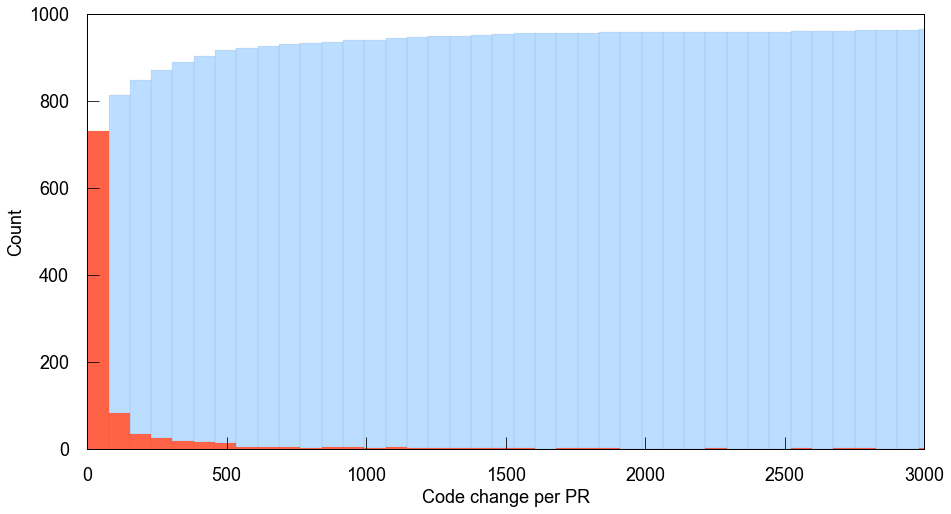

In [87]:
plt.figure(figsize=(15, 8))
sns.histplot(changes, bins=2000, cumulative=True, color="dodgerblue", alpha=0.3)
sns.histplot(changes, bins=2000, cumulative=False, color="tomato", alpha=1)
plt.xlim(0, 3000)
plt.ylim(0, 1000)
plt.xlabel("Code change per PR", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.show()

In [97]:
median(changes)

16.0

In [102]:
stdev(changes)

6036.876481977883

他の言語ではどうなっているか？

## Rust

### １つのPRに何個のCommit が含まれているか

In [60]:
repos_rs = {
    "rust": "rust-lang",
    "servo": "servo",
    "Rocket": "SergioBenitez",
    "actix-web": "actix",
    "tokio": "tokio-rs",
    "hyper": "hyperium",
    "cargo": "rust-lang",
    "serde": "serde-rs"
}

commits_per_prs_rs = []

for repo, owner in tqdm(repos_rs.items()):
    query = '{\n    repository(name: "' + repo + '", owner: "' + owner + '") {' + \
    """
        pullRequests(first: 100) {
            nodes {
                commits(first: 1) {
                    totalCount
                }
            }
        }
    }
}
    """
    result = run_query(query)
    prs = result["data"]["repository"]["pullRequests"]["nodes"]
    
    for pr in prs:
        commits_per_prs_rs.append(pr["commits"]["totalCount"])

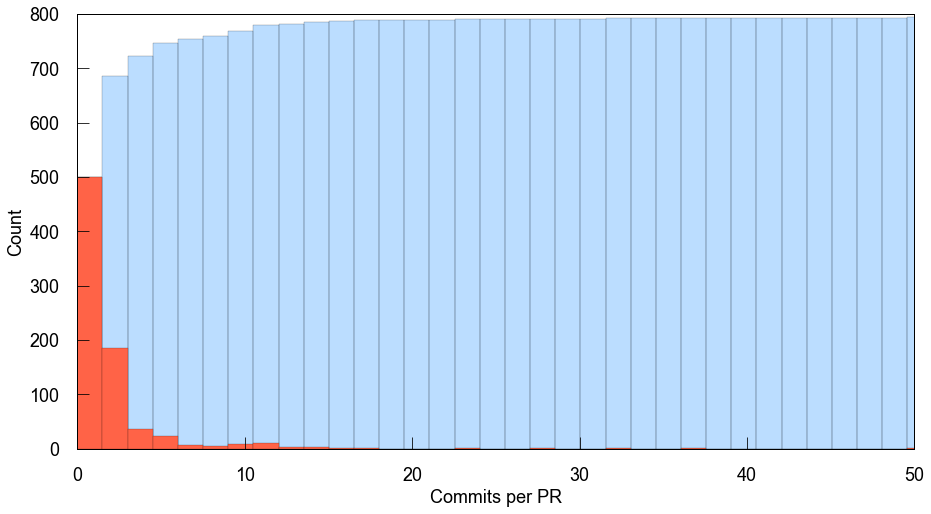

In [88]:
plt.figure(figsize=(15, 8))
sns.histplot(commits_per_prs_rs, bins=400, cumulative=True, color="dodgerblue", alpha=0.3)
sns.histplot(commits_per_prs_rs, bins=400, cumulative=False, color="tomato", alpha=1)
plt.xlim(0, 50)
plt.ylim(0, 800)
plt.xlabel("Commits per PR", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.show()

In [98]:
median(commits_per_prs_rs)

1.0

In [106]:
stdev(commits_per_prs_rs)

45.50577730516955

### 1つのPRの変更差分はどれくらいか

In [7]:
repos_rs = {
    "rust": "rust-lang",
    "servo": "servo",
    "Rocket": "SergioBenitez",
    "actix-web": "actix",
    "tokio": "tokio-rs",
    "hyper": "hyperium",
    "cargo": "rust-lang",
    "serde": "serde-rs"
}

changes_rs = []

for repo, owner in tqdm(repos_rs.items()):
    query = '{\n    repository(name: "' + repo + '", owner: "' + owner + '") {' + \
    """
        pullRequests(first: 100) {
            nodes {
                commits(first: 15) {
                    nodes {
                        commit {
                            additions
                            deletions
                        }
                    }
                }
            }
        }
    }
}
    """
    try:
        result = run_query(query)
    except:
        continue
        
    prs = result["data"]["repository"]["pullRequests"]["nodes"]
    
    for pr in prs:
        tmp = 0
        commits = pr["commits"]["nodes"]
        for commit in commits:
            tmp += commit["commit"]["additions"]
        
        changes_rs.append(tmp)

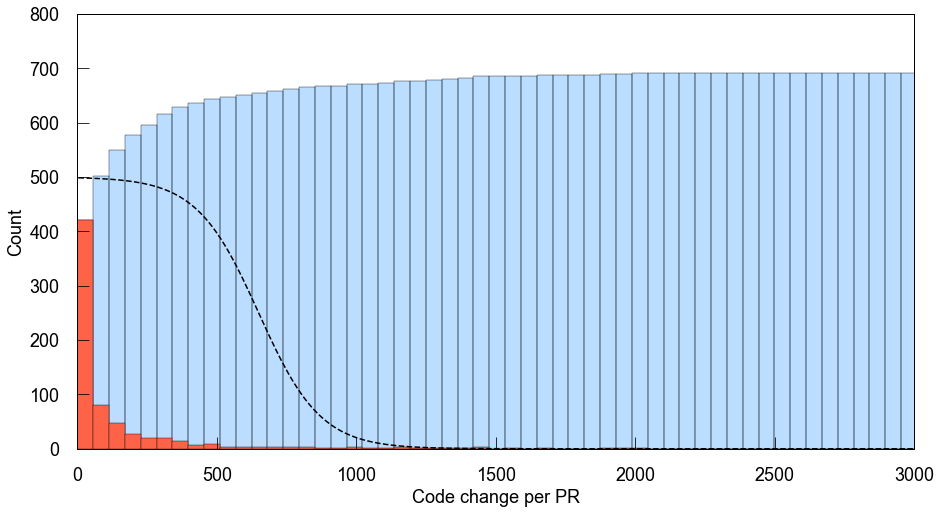

In [68]:
x = np.linspace(-3000, 3000, 1000)

plt.figure(figsize=(15, 8))
sns.histplot(changes_rs, bins=200, cumulative=True, color="dodgerblue", alpha=0.3)
sns.histplot(changes_rs, bins=200, cumulative=False, color="tomato", alpha=1)
plt.plot(x, fermi(x, beta = 0.009, mu=650)* 500, "k--")
plt.xlim(0, 3000)
plt.ylim(0, 800)
plt.xlabel("Code change per PR", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.show()

In [99]:
median(changes_rs)

29.0

In [107]:
stdev(changes_rs)

832.1144401314531

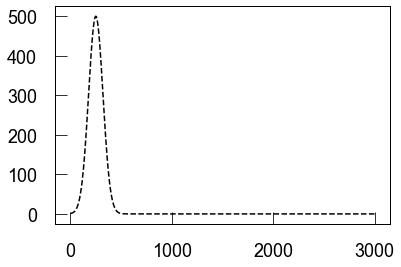

In [45]:
plt.plot(x, 500*np.exp(-(x-250)**2 * 1e-4), "k--")
plt.show()